# The Neighborhoods of Paris

## Introduction & Business Problem

Paris, the captial of France, is a large and diverse city. As a tourist or as someone moving there you will have to choose where to stay, what to visit or where to live.

The aim of this investigation is to provide a quantitative comparison of the 20 neighborhoods (Arrondissements) of the city of Paris. We compare the neighborhoods according to two metrics: (i) whether the neighborhood offers more recreational venues versus entertainment venues and (ii) whether the restaurants of the neighborhood offer more French versus more International cuisine.

## Data

The data we need to come up with the above mentioned metrics is the following:
    
    - A names of all the neighborhoods
    - The geographical coordinates of the neighborhoods
    - For each neighborhood the most common venues
    
To get the names and coordinates of the 20 arrondissements (neighborhoods) we use web scraping of the relevant Wikipedia pages.

We use the Foursquare API to obtain the list of the venues of all the neighborhoods. We then do a frequency ananlysis to come up with the 10 most frequent venue categories.

Finally, we group the venues in four categories: French Eating, International Eating, Recreation, and Entertainment. The first two categories lead to the Eating metric, the latter two to the Leisure metric. By going through the list of the most common venues for every neighborhood and assigning the venues to the categories we compute the metrics. More frequent venue categories lead to more points.
    

In [1]:
!pip install lxml beautifulsoup4

     |████████████████████████████████| 5.5MB 5.9MB/s eta 0:00:01     |███▏                            | 542kB 5.9MB/s eta 0:00:01     |███████████                     | 1.9MB 5.9MB/s eta 0:00:01     |████████████████████▍           | 3.5MB 5.9MB/s eta 0:00:01
     |████████████████████████████████| 122kB 7.5MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import requests
import urllib
import lxml.html
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import time

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

### Dataframe with PostalCodes and Coordinates of all Arrondissements in Paris ##

In [19]:
dfs = pd.read_html('https://fr.wikipedia.org/wiki/Arrondissements_de_Paris',header=0)[3]
dfs

,Arr.,Nom,Superficie(ha),Population (municipale pour 2010 et 2015),Population (municipale pour 2010 et 2015).1,Population (municipale pour 2010 et 2015).2,Population (municipale pour 2010 et 2015).3,Population (municipale pour 2010 et 2015).4,Population (municipale pour 2010 et 2015).5,Population (municipale pour 2010 et 2015).6,Densité (hab./km²),Densité (hab./km²).1,Densité (hab./km²).2,Densité (hab./km²).3,Densité (hab./km²).4,Densité (hab./km²).5
0,Arr.,Nom,Superficie(ha),1872,1954,1999,2006,2010,2015,2017,1872,1954,1999,2006,2010,2015
1,1er,Louvre,183,74 286,38 926,16 888,17 745,17 308,16 545,16 395,40 593,21 271,9 228,9 697,9 458,9 041
2,2e,Bourse,99,73 578,43 857,19 585,21 259,23 009,20 796,21 042,74 321,44 300,19 783,21 474,23 241,21 006
3,3e,Temple,117,89 687,65 312,34 248,34 721,35 652,35 049,34 389,76 656,55 822,29 272,29 676,30 472,29 956
4,4e,Hôtel-de-Ville,160,95 003,66 621,30 675,28 268,28 012,27 146,28 370,59 377,41 638,19 172,18 211,17 507,16 966
5,5e,Panthéon,254,96 689,106 443,58 849,61 475,60 938,59 333,59 631,38 067,41 907,23 169,24 203,23 991,23 359
6,6e,Luxembourg,215,90 288,88 200,44 919,45 278,43 451,42 428,41 976,41 994,41 023,20 893,21 060,20 210,19 734
7,7e,Palais-Bourbon,409,78 553,104 412,56 985,56 612,57 974,54 133,52 193,19 206,25 529,13 933,13 842,14 175,13 235
8,8e,Élysée,388,75 796,80 827,39 314,39 088,41 280,36 694,37 367,19 535,20 832,10 132,10 074,10 639,9 457
9,9e,Opéra[note 1],218,103 767,102 287,55 838,58 497,60 139,59 408,60 071,47 600,46 921,25 614,26 833,27 587,27 251


In [21]:
parisdf=pd.DataFrame({'Arrondissement': dfs['Arr.'].values[1:-3],
                     'Nom': dfs['Nom'].values[1:-3],
                     'Population': dfs['Population (municipale pour 2010 et 2015).6'].values[1:-3],
                     'Area': dfs['Superficie(ha)'].values[1:-3]})

Remove non-line breaking characters from the strings.

In [23]:
parisdf['Population']=parisdf['Population'].str.replace('\xa0', '')
parisdf['Area']=parisdf['Area'].str.replace('\xa0', '')

Scrape the geographical coordinates from the individual Wikipedia pages of the arrondissements.

In [6]:
latitudes = []
longitudes = []
for arr in range(1,21):
    if arr==1:
        codeurl = "1er"
    else:
        codeurl =  str(arr)+'e'
        
    #url = 'https://postal-codes.cybo.com/italy/00124_rome/'
    url='https://fr.wikipedia.org/wiki/'+codeurl+'_arrondissement_de_Paris'
    
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "lxml")
    element = soup.find(text='Coordonnées')
    tempLat = float((str(element.parent.parent.parent).split('data-lat="')[1]).split('"')[0])
    tempLong = float((str(element.parent.parent.parent).split('data-lon="')[1]).split('"')[0])
    
    latitudes.append(tempLat)
    longitudes.append(tempLong)
    print(codeurl)

1er
2e
3e
4e
5e
6e
7e
8e
9e
10e
11e
12e
13e
14e
15e
16e
17e
18e
19e
20e


In [24]:
parisdf['Latitude']=latitudes
parisdf['Longitude']=longitudes
parisdf['Population']=parisdf['Population'].astype(int)
parisdf['Area']=parisdf['Area'].astype(int)


In [25]:
parisdf

,Arrondissement,Nom,Population,Area,Latitude,Longitude
0,1er,Louvre,16395,183,48.859947,2.342059
1,2e,Bourse,21042,99,48.866889,2.340470
2,3e,Temple,34389,117,48.864027,2.361531
3,4e,Hôtel-de-Ville,28370,160,48.856185,2.355682
4,5e,Panthéon,59631,254,48.846197,2.344615
5,6e,Luxembourg,41976,215,48.850565,2.332733
6,7e,Palais-Bourbon,52193,409,48.856903,2.319945
7,8e,Élysée,37367,388,48.877816,2.317807
8,9e,Opéra[note 1],60071,218,48.872481,2.340415
9,10e,"Entrepôt, anciennement Enclos Saint-Laurent",90836,289,48.871899,2.357399


In [26]:
parisdf.to_csv('ParisGeoData.csv')

In [5]:
parisdf = pd.read_csv('ParisGeoData.csv')

In [6]:
venues_map = folium.Map(location=[parisdf['Latitude'][0], parisdf['Longitude'][0]], zoom_start=13, control_scale=True) # generate map centred around the Conrad Hotel


for lat, lng, name in zip(parisdf['Latitude'], parisdf['Longitude'],parisdf['Nom']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip = name,
        popup = name,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)


In [7]:
venues_map

In [30]:
venues_map.save('Paris.html')

In [ ]:
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(name+' failed')
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
paris_venues = getNearbyVenues(names=parisdf['Arrondissement'],
                                   latitudes=parisdf['Latitude'],
                                   longitudes=parisdf['Longitude']
                                  )

1er
2e
3e
4e
5e
6e
7e
8e
9e
10e
11e
12e
13e
14e
15e
16e
17e
18e
19e
20e


In [48]:
paris_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1er,48.859947,2.342059,Place du Louvre,48.859841,2.340822,Plaza
1,1er,48.859947,2.342059,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
2,1er,48.859947,2.342059,Boutique yam'Tcha,48.861710,2.342380,Chinese Restaurant
3,1er,48.859947,2.342059,Le Fumoir,48.860424,2.340868,Cocktail Bar
4,1er,48.859947,2.342059,Coffee Crêpes,48.858841,2.340802,Coffee Shop
...,...,...,...,...,...,...,...
1374,20e,48.865099,2.399032,Gambetta,48.868616,2.401964,Café
1375,20e,48.865099,2.399032,Un Zèbre Ô Grenier,48.865809,2.394345,Kids Store
1376,20e,48.865099,2.399032,Franprix Rue des prairies,48.862800,2.403034,Food & Drink Shop
1377,20e,48.865099,2.399032,Square Samuel de Champlain,48.864330,2.393314,Garden


In [49]:
len(paris_venues['Venue Category'].unique())

203

In [50]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Arrondissement'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Arrondissement,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,1er,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1er,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1er,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1er,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1er,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
paris_grouped = paris_onehot.groupby('Arrondissement').mean().reset_index()
paris_grouped

,Arrondissement,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,10e,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000
1,11e,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,0.000000,...,0.000000,0.000000,0.000000,0.00,0.023256,0.011628,0.011628,0.046512,0.000000,0.011628
2,12e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023256,0.000000,0.023256,0.00,0.000000,0.000000,0.023256,0.023256,0.000000,0.000000
3,13e,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000
4,14e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.020000,0.020000,0.020000,0.000000
5,15e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000
6,16e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032258,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,17e,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,0.010204,0.000000,0.000000,...,0.000000,0.000000,0.010204,0.00,0.010204,0.000000,0.010204,0.071429,0.000000,0.000000
8,18e,0.000000,0.016667,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.016667,0.016667,0.000000,0.000000
9,19e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000


In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Arrondissement']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Arrondissement'] = paris_grouped['Arrondissement']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Arrondissement,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10e,French Restaurant,Hotel,Coffee Shop,Cocktail Bar,Bar,Bakery,Pizza Place,Breakfast Spot,Bistro,Korean Restaurant
1,11e,French Restaurant,Bar,Café,Wine Bar,Cocktail Bar,Italian Restaurant,Bistro,Pastry Shop,Restaurant,Supermarket
2,12e,Hotel,Bistro,French Restaurant,Supermarket,Chinese Restaurant,Indian Restaurant,Creperie,Sandwich Place,Café,Cheese Shop
3,13e,Hotel,Thai Restaurant,French Restaurant,Vietnamese Restaurant,Bar,Indian Restaurant,Bakery,Italian Restaurant,Convenience Store,Moroccan Restaurant
4,14e,French Restaurant,Italian Restaurant,Hotel,Bar,Garden,Bakery,Bistro,Latin American Restaurant,Food & Drink Shop,Metro Station


In [84]:
neighborhoods_venues_sorted.shape

(20, 11)

In [59]:
np.unique(neighborhoods_venues_sorted[neighborhoods_venues_sorted.columns[1:]])

array(['Art Gallery', 'Art Museum', 'Bakery', 'Bar', 'Beer Garden',
       'Bistro', 'Breakfast Spot', 'Burger Joint', 'Bus Station',
       'Bus Stop', 'Café', 'Cheese Shop', 'Chinese Restaurant',
       'Chocolate Shop', 'Clothing Store', 'Cocktail Bar', 'Coffee Shop',
       'Concert Hall', 'Convenience Store', 'Cosmetics Shop', 'Creperie',
       'Deli / Bodega', 'Food & Drink Shop', 'French Restaurant',
       'Garden', 'Gastropub', 'Gay Bar', 'Gourmet Shop',
       'Gym / Fitness Center', 'Hotel', 'Ice Cream Shop',
       'Indian Restaurant', 'Indie Movie Theater', 'Italian Restaurant',
       'Japanese Restaurant', 'Jazz Club', 'Korean Restaurant',
       'Latin American Restaurant', 'Lebanese Restaurant',
       'Metro Station', 'Moroccan Restaurant', 'Park', 'Pastry Shop',
       'Pharmacy', 'Pizza Place', 'Plaza', 'Pool', 'Pub', 'Restaurant',
       'Salad Place', 'Sandwich Place', 'Seafood Restaurant',
       'Supermarket', 'Sushi Restaurant', 'Thai Restaurant', 'Theater',
 

In [60]:
frenchEating = ['Creperie','French Restaurant','Bistro']
internationalEating =['Thai Restaurant','Sushi Restaurant','Vietnamese Restaurant',
                      'Moroccan Restaurant','Latin American Restaurant','Chinese Restaurant',
                      'Indian Restaurant', 'Italian Restaurant','Japanese Restaurant',
                      'Korean Restaurant', 'Lebanese Restaurant']
recreation = ['Park','Pool','Plaza','Garden', 'Gym / Fitness Center']
entertainment = ['Art Gallery','Art Museum','Concert Hall','Indie Movie Theater','Jazz Club','Pub','Theater','Wine Bar','Cocktail Bar','Beer Garden','Bar']

In [94]:
topTen = neighborhoods_venues_sorted.columns[1:].values
eatingScores = []
leisureScores = []
for row in range(0,20):
    
    eating = 0
    leisure = 0
    for spot in range(0,10):
        if neighborhoods_venues_sorted.iloc[row][topTen[spot]] in frenchEating:
            eating +=(10-spot)**1
        if neighborhoods_venues_sorted.iloc[row][topTen[spot]] in internationalEating:
            eating -=(10-spot)**1
        if neighborhoods_venues_sorted.iloc[row][topTen[spot]] in recreation:
            leisure +=(10-spot)**1
        if neighborhoods_venues_sorted.iloc[row][topTen[spot]] in entertainment:
            leisure -=(10-spot)**1
    eatingScores.append(eating)
    leisureScores.append(leisure)
    

In [95]:
parisRatingDF = pd.DataFrame({'Arrondissement': neighborhoods_venues_sorted['Arrondissement'],
                             'Eating': eatingScores,
                             'Leisure': leisureScores})

In [97]:
parisRatingDF.to_csv('ParisRatings.csv')

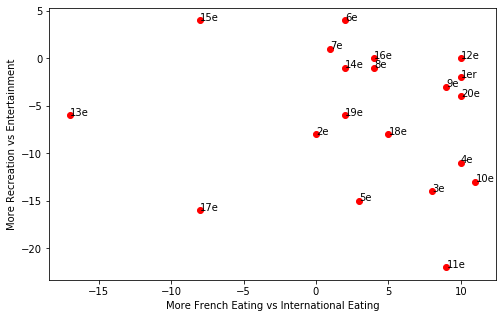

In [96]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.plot(parisRatingDF['Eating'], parisRatingDF['Leisure'],'ro')

for i, txt in enumerate(parisRatingDF['Arrondissement']):
    ax.annotate(txt, (parisRatingDF['Eating'][i],parisRatingDF['Leisure'][i]))
plt.xlabel('More French Eating vs International Eating')
plt.ylabel('More Recreation vs Entertainment')
plt.show()